<a href="https://colab.research.google.com/github/pg1992/IA025_2022S1/blob/main/ex04/pedro_moreira/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

def MyDataLoader(dataset, batch_size):
  batches = []
  num_items = len(dataset)
  index = 0
  while num_items > 0:
    indices = range(index, min(index + batch_size, len(dataset)))
    x = torch.cat([dataset[i][0][None, :] for i in indices], 0)
    y = torch.Tensor([dataset[i][1] for i in indices]).to(torch.long)
    batches.append([x, y])
    num_items -= len(indices)
    index += len(indices)
  return batches

loader_train = MyDataLoader(dataset_train, batch_size)

In [7]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [8]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class MyModel:
  def __init__(self, in_features: int, out_features: int):
    self.weight = torch.empty([in_features, out_features], requires_grad=True)
    self.bias = torch.empty([out_features], requires_grad=True)

  def __call__(self, input):
    return torch.mm(input, self.weight) + self.bias

  def parameters(self):
    return self.weight, self.bias

  def load_state_dict(self, state_dict: dict):
    self.weight = state_dict['weight']
    self.bias = state_dict['bias']
    self.weight.requires_grad = True
    self.bias.requires_grad = True

model = MyModel(28*28, 10)
model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

## Treinamento

### Inicialização dos parâmetros

In [9]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [10]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

class MyCrossEntropyLoss:
  def __call__(self, outputs, target):
    exps = torch.exp(outputs - torch.max(outputs))
    sums = torch.sum(exps, dim=1, keepdim=True)
    softs =  exps / sums
    cross_entropies = -torch.mean(torch.eye(10)[target] * torch.log(softs), dim=0)
    return torch.sum(cross_entropies)

criterion = MyCrossEntropyLoss()

# Definição do Optimizer

In [11]:
# Escreva aqui o equivalente de:
optimizer = torch.optim.SGD(model.parameters(), lr)

class MySGD:
  def __init__(self, params, lr):
    self.params = params
    self.lr = lr

  def zero_grad(self):
    for p in self.params:
      if p.grad is not None:
        p.grad.zero_()

  def step(self):
    with torch.no_grad():
      for p in self.params:
        p.copy_(p - self.lr * p.grad)

my_optimizer = MySGD(model.parameters(), lr)


### Laço de treinamento dos parâmetros

In [12]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:2d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch:  0/49 Loss: 1.1979684829711914
Epoch:  1/49 Loss: 0.867622971534729
Epoch:  2/49 Loss: 0.7226786613464355
Epoch:  3/49 Loss: 0.6381281018257141
Epoch:  4/49 Loss: 0.5809750556945801
Epoch:  5/49 Loss: 0.5387411117553711
Epoch:  6/49 Loss: 0.5056463479995728
Epoch:  7/49 Loss: 0.4786270260810852
Epoch:  8/49 Loss: 0.4558936655521393
Epoch:  9/49 Loss: 0.4363219141960144
Epoch: 10/49 Loss: 0.4191649854183197
Epoch: 11/49 Loss: 0.403904527425766
Epoch: 12/49 Loss: 0.3901680111885071
Epoch: 13/49 Loss: 0.3776799440383911
Epoch: 14/49 Loss: 0.36623144149780273
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584274888038635
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.32807356119155884
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123183846473694
Epoch: 21/49 Loss: 0.3050611615180969
Epoch: 22/49 Loss: 0.29816246032714844
Epoch: 23/49 Loss: 0.2915884852409363
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930304408073425
Epoch

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

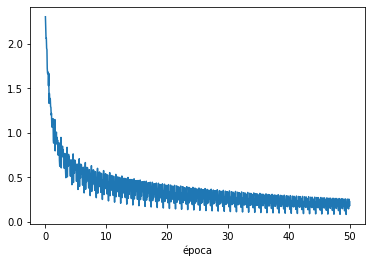

In [13]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

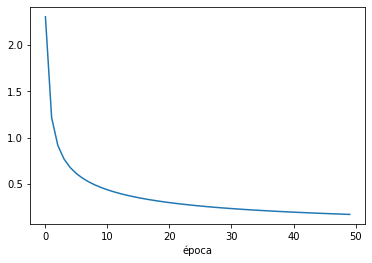

In [14]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [15]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [16]:
def softmax(x):
  m = torch.max(x)
  e = torch.exp(x - m)
  return e / torch.sum(e)

results = []
for i in range(len(dataset_train_full)):
  image = torch.Tensor(dataset_train_full[i][0]).reshape(28, 28)
  ps = softmax(model(image.view(-1, 28*28)))
  prob = ps.max()
  k = int((ps == prob).nonzero(as_tuple=True)[0])
  expected = dataset_train_full[i][1]
  results.append(dict(image=image, k=k, prob=prob, expected=expected))

In [17]:
correct = [res for res in results if res['k'] == res['expected']]
wrong = [res for res in results if res['k'] != res['expected']] 

Text(0.5, 1.0, 'Amostra classificada corretamente, com maior probabilidade (k=0, prob=0.9999459981918335)')

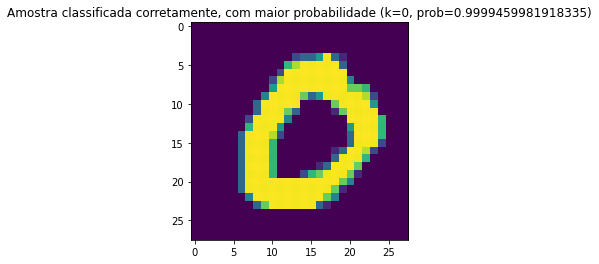

In [18]:
max_correct = max(correct, key=lambda r: r['prob'])
plt.imshow(max_correct['image'])
plt.title(f"Amostra classificada corretamente, com maior probabilidade (k={max_correct['k']}, prob={max_correct['prob']})")

Text(0.5, 1.0, 'Amostra classificada erradamente, com maior probabilidade (k=0, prob=0.9999954700469971)')

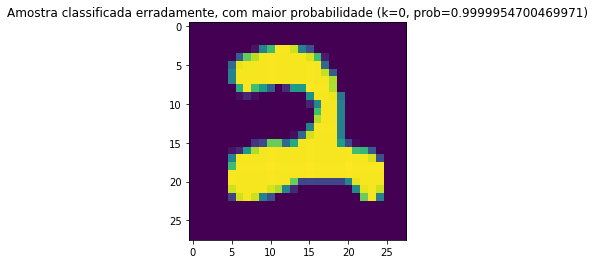

In [19]:
max_wrong = max(wrong, key=lambda r: r['prob'])
plt.imshow(max_wrong['image'])
plt.title(f"Amostra classificada erradamente, com maior probabilidade (k={max_wrong['k']}, prob={max_wrong['prob']})")

Text(0.5, 1.0, 'Amostra classificada corretamente, com menor probabilidade (k=0, prob=0.2348218858242035)')

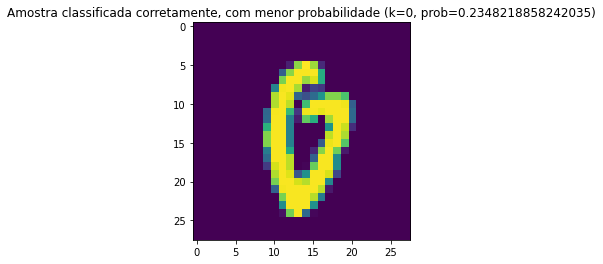

In [20]:
min_correct = min(correct, key=lambda r: r['prob'])
plt.imshow(min_correct['image'])
plt.title(f"Amostra classificada corretamente, com menor probabilidade (k={min_correct['k']}, prob={min_correct['prob']})")

Text(0.5, 1.0, 'Amostra classificada erradamente, com menor probabilidade (k=0, prob=0.16754816472530365)')

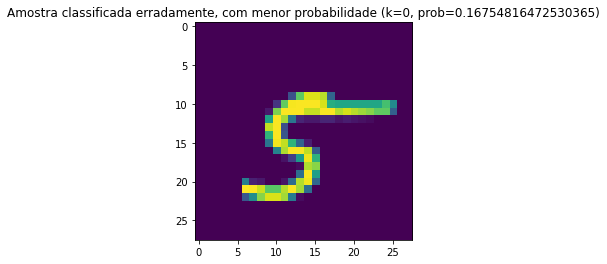

In [21]:
min_wrong = min(wrong, key=lambda r: r['prob'])
plt.imshow(min_wrong['image'])
plt.title(f"Amostra classificada erradamente, com menor probabilidade (k={min_wrong['k']}, prob={min_wrong['prob']})")

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
